### Explore locally cached Argo oxygen float data - second in a series of Notebooks
*Use the biofloat module to get data and Pandas to operate on it for testing ability to easily perform calibrations*

(See [build_biofloat_cache.ipynb](https://github.com/MBARIMike/biofloat/blob/master/notebooks/build_biofloat_cache.ipynb) for for the work that leads to this Notebook.)

Get an ArgoData object that uses the default local cache.

In [1]:
from biofloat import ArgoData
ad = ArgoData()

Get the default list of floats that have oxygen data.

In [2]:
wmo_list = ad.get_oxy_floats_from_status()

We can explore the distribution of AGEs of the Argo floats by getting the status data in a DataFrame (`sdf`). 

In [3]:
sdf, _ = ad._get_df(ad._STATUS)
sdf.ix[:, 'WMO':'GREYLIST'].head()

,WMO,TELECOM,TTYPE,MY_ID,SERIAL_NO,DATE0,NOTIF_DATE,MONTH0,YEAR0,LAT0,...,EMAIL,PROGRAM,COUNTRY,AGE,AGE_WEIGHT,GTS,PROFILES,DMPROFILES,GTSPRESS,GREYLIST
0,3900380,27643,ARGOS,,1510,09/02/2005,11/02/2005,2,2005,-56.4700,...,jon.turton@metoffice.gov.uk,Argo UK,UNITED KINGDOM,0.0000,0,0,0,0,0,0
1,3900381,27645,ARGOS,,1511,09/02/2005,11/02/2005,2,2005,-58.7800,...,jon.turton@metoffice.gov.uk,Argo UK,UNITED KINGDOM,1681.1643,0,1,168,168,2003,0
2,3900382,27652,ARGOS,,1512,09/02/2005,11/02/2005,2,2005,-57.4900,...,jon.turton@metoffice.gov.uk,Argo UK,UNITED KINGDOM,0.0000,0,0,0,0,0,0
3,3900399,46233,ARGOS,1201,,07/02/2005,14/02/2005,2,2005,-25.2461,...,probbins@whoi.edu,Argo WHOI,UNITED STATES,2001.7359,0,1,201,201,1822,1
4,3900400,46234,ARGOS,1202,,09/02/2005,14/02/2005,2,2005,-22.7369,...,probbins@whoi.edu,Argo WHOI,UNITED STATES,1941.0619,0,1,195,195,1793,1


Define a function (`dist_plot`) and plot the distribution of the AGE column.

Populating the interactive namespace from numpy and matplotlib


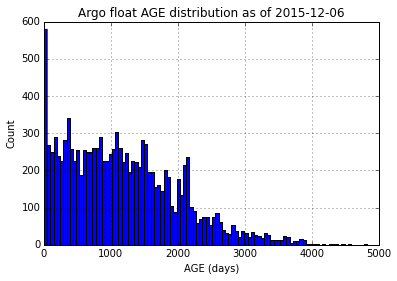

In [4]:
%pylab inline
def dist_plot(df, title):
    from datetime import date
    ax = df.hist(bins=100)
    ax.set_xlabel('AGE (days)')
    ax.set_ylabel('Count')
    ax.set_title('{} as of {}'.format(title, date.today()))
    
dist_plot(sdf['AGE'], 'Argo float AGE distribution')

There are over 600 floats with an AGE of 0. The `.get_oxy_floats_from_status()` method does not select these floats as I believe they are 'inactive'.  Let's count the number of non-greylisted oxygen floats at various AGEs so that we can build a reasonably sized test cache.

Count age_gte 0340: 573
Count age_gte 1000: 319
Count age_gte 2000: 52
Count age_gte 2200: 19
Count age_gte 3000: 1


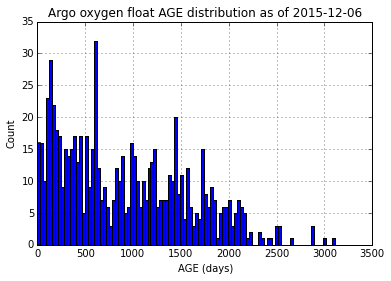

In [5]:
sdfq = sdf.query('(AGE != 0) & (OXYGEN == 1) & (GREYLIST != 1)')
dist_plot(sdfq['AGE'], title='Argo oxygen float AGE distribution')
print 'Count age_gte 0340:', len(sdfq.query('AGE >= 340'))
print 'Count age_gte 1000:', len(sdfq.query('AGE >= 1000'))
print 'Count age_gte 2000:', len(sdfq.query('AGE >= 2000'))
print 'Count age_gte 2200:', len(sdfq.query('AGE >= 2200'))
print 'Count age_gte 3000:', len(sdfq.query('AGE >= 3000'))

Compare the 2200 count with what `.get_oxy_floats_from_status(age_gte=2200)` returns.

In [6]:
len(ad.get_oxy_floats_from_status(age_gte=2200))

19

That's reassuring! Now, let's build a custom cache file of 2 profile from the 19 floats that have an AGE >= 2200 days.

From a shell or Anaconda prompt window execute:

```bash
load_biofloat_cache.py --age 2200 --profiles 2 -v
```
This will take several minutes to download the data and build the cache. Once it's finished you can execute the cells below (you will need to enter the exact name of the cache_file which the above command displays in its INFO messages). By default `load_biofloat_cache.py` places cache files in the users home directory, the cell below joins the home directory with the short version of the file created by the above command.

If you have done a `pip install biofloat` then `load_biofloat_cache.py` will be in your search path and the above command will work. On Windows computers a `load_biofloat_cache.bat` file is installed in the search path, so on Windows you should execute:

```bash
load_biofloat_cache --age 2200 --profiles 2 -v
```

If this doesn't work then confirm that your `python` command is the correct version and  execute like:

```bash
python <full_path_to_load_biofloat_cache.py file> --age 2200 --profiles 2 -v
```

In [7]:
%%time
from os.path import expanduser, join
ad.set_verbosity(2)
ad = ArgoData(cache_file = join(expanduser('~'), 
     'biofloat_fixed_cache_age2200_profiles2_variablesDOXY_ADJUSTED-PSAL_ADJUSTED-TEMP_ADJUSTED.hdf'))
wmo_list = ad.get_oxy_floats_from_status(2200)
# Use 'update_cache=False' to avoid doing lookups for new profile data
df = ad.get_float_dataframe(wmo_list, max_profiles=2, update_cache=False)

CPU times: user 313 ms, sys: 13 ms, total: 326 ms
Wall time: 384 ms


Plot the profiles.

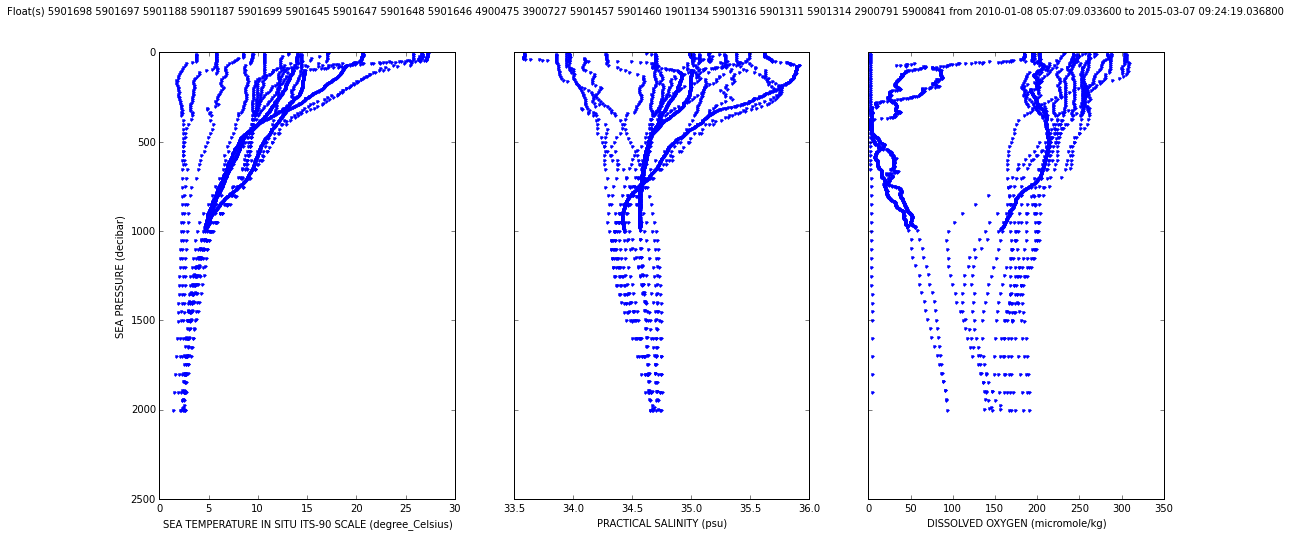

In [8]:
# Parameter long_name and units copied from attributes in NetCDF files
time_range = '{} to {}'.format(df.index.get_level_values('time').min(), 
                               df.index.get_level_values('time').max())
parms = {'TEMP_ADJUSTED': 'SEA TEMPERATURE IN SITU ITS-90 SCALE (degree_Celsius)', 
         'PSAL_ADJUSTED': 'PRACTICAL SALINITY (psu)',
         'DOXY_ADJUSTED': 'DISSOLVED OXYGEN (micromole/kg)'}

plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, len(parms), sharey=True)
ax[0].invert_yaxis()
ax[0].set_ylabel('SEA PRESSURE (decibar)')

for i, (p, label) in enumerate(parms.iteritems()):
    ax[i].set_xlabel(label)
    ax[i].plot(df[p], df.index.get_level_values('pressure'), '.')
    
plt.suptitle('Float(s) ' + ' '.join(wmo_list) + ' from ' + time_range)

Plot the profiles on a map.

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


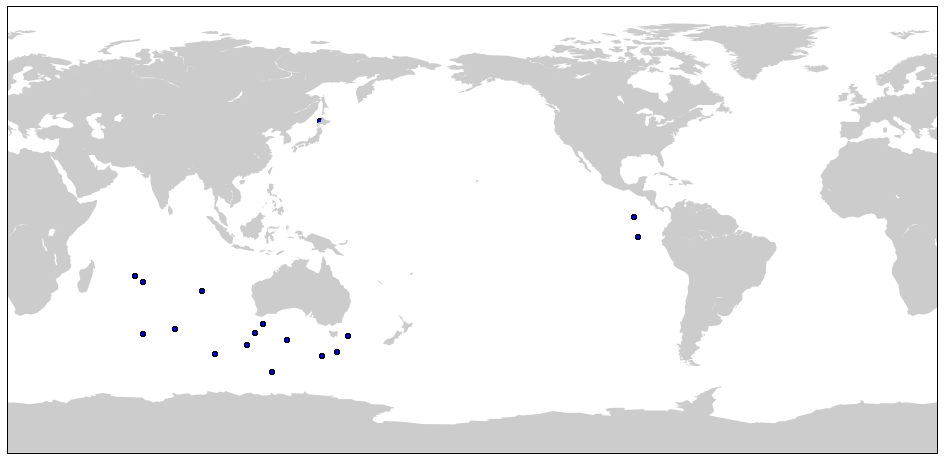

In [9]:
import pylab as plt
from mpl_toolkits.basemap import Basemap

plt.rcParams['figure.figsize'] = (18.0, 8.0)
m = Basemap(llcrnrlon=15, llcrnrlat=-90, urcrnrlon=390, urcrnrlat=90, projection='cyl')
m.fillcontinents(color='0.8')

m.scatter(df.index.get_level_values('lon'), df.index.get_level_values('lat'), latlon=True)